## Import Library

In [1]:
import os
import json
import warnings
import pandas as pd
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import (
    StratifiedKFold, GridSearchCV, cross_val_score
)
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, roc_auc_score, roc_curve, confusion_matrix,
    classification_report, f1_score, precision_recall_curve, average_precision_score,
    recall_score,
)
import joblib
from catboost import CatBoostClassifier
from IPython.display import display

import optuna

warnings.filterwarnings('ignore', category=UserWarning)

project_path = "E:/Project/HepatitisC-Prediction/"
file_path = f"{project_path}/Dataset/cleaned_dataset.csv"
result_path = f"{project_path}/Result"
hyper_path = f"{result_path}/Hyperparameter"
model_path = f"{project_path}/Models"

## Load Dataset

In [2]:
df = pd.read_csv(file_path)
print(df.shape)
print(df.info())

(3687, 28)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3687 entries, 0 to 3686
Data columns (total 28 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  3687 non-null   int64  
 1   gender               3687 non-null   int64  
 2   jaundice_history     3687 non-null   int64  
 3   receive_transfusion  3687 non-null   int64  
 4   liver_condition      3687 non-null   int64  
 5   injectable_drug_use  3687 non-null   int64  
 6   drug_use             3687 non-null   int64  
 7   alcohol_consumption  3687 non-null   int64  
 8   alt                  3687 non-null   float64
 9   albumin              3687 non-null   float64
 10  alp                  3687 non-null   float64
 11  ast                  3687 non-null   float64
 12  bun                  3687 non-null   float64
 13  cholesterol          3687 non-null   float64
 14  cpk                  3687 non-null   float64
 15  creatinine           3687 n

In [3]:
df_train = df[df['dataset'] == 'train']
df_test = df[df['dataset'] == 'test']

X_train = df_train.drop(columns=['hcv_status', 'dataset'])
y_train = df_train['hcv_status']

X_test = df_test.drop(columns=['hcv_status', 'dataset'])
y_test = df_test['hcv_status']

print(f"Train shape: {X_train.shape}")
print(f"Test shape: {X_test.shape}")

Train shape: (3198, 26)
Test shape: (489, 26)


## Hyperparameter Tuning (5-Fold CV)

In [4]:
numeric_features_to_scale = ['age', 'alt', 'albumin', 'alp', 'ast', 'bun', 'cholesterol', 'cpk', 'creatinine', 'ggt', 'glucose', 'total_bilirubin', 'total_calcium', 'total_protein', 'triglycerides', 'uric_acid', 'ldh', 'globulin', 'osmolality']
categorical_features = ['gender', 'education_level', 'receive_transfusion', 'liver_condition', 'injectable_drug_use', 'drug_use', 'alcohol_consumption']

# Buat preprocessor (akan di-fit dalam Pipeline)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features_to_scale)
    ],
    remainder='passthrough'
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [5]:
def objective(trial):
    iterations = trial.suggest_int("iterations", 100, 200)  
    learning_rate = trial.suggest_float("learning_rate", 0.03, 0.08)
    depth = trial.suggest_int("depth", 4, 6)
    l2_leaf_reg = trial.suggest_int("l2_leaf_reg", 3, 7)
    min_data_in_leaf = trial.suggest_int("min_data_in_leaf", 5, 20)

    model = Pipeline([
        ('scaler', preprocessor),
        ('classifier', CatBoostClassifier(
            iterations=iterations,
            learning_rate=learning_rate,
            depth=depth,
            l2_leaf_reg=l2_leaf_reg,
            min_data_in_leaf=min_data_in_leaf,
            verbose=False,
            loss_function="Logloss",
            allow_writing_files=False,
            random_state=42,
        ))
    ])

    train_acc_list = []
    val_acc_list = []
    val_recall_list = []

    for train_idx, valid_idx in cv.split(X_train, y_train):
        X_t, X_v = X_train.iloc[train_idx], X_train.iloc[valid_idx]
        y_t, y_v = y_train.iloc[train_idx], y_train.iloc[valid_idx]

        model.fit(X_t, y_t)

        train_pred = model.predict(X_t)
        train_acc = accuracy_score(y_t, train_pred)
        train_acc_list.append(train_acc)

        val_pred = model.predict(X_v)
        val_acc = accuracy_score(y_v, val_pred)
        val_recall = recall_score(y_v, val_pred, average="macro")

        val_acc_list.append(val_acc)
        val_recall_list.append(val_recall)

    mean_train_acc = np.mean(train_acc_list)
    mean_val_acc = np.mean(val_acc_list)
    mean_val_recall = np.mean(val_recall_list)

    print(f"Trial {trial.number}: "
          f"Train Acc = {mean_train_acc:.4f}, "
          f"Val Acc = {mean_val_acc:.4f}, "
          f"Val Recall = {mean_val_recall:.4f}")

    return mean_val_recall


In [6]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

print("\n" + "=" * 60)
print("Tuning Selesai!")
print("=" * 60)


[I 2025-12-08 21:15:27,144] A new study created in memory with name: no-name-ae0bafee-df94-4aac-9fc0-382d5cee758f
[I 2025-12-08 21:15:28,825] Trial 0 finished with value: 0.9630965909090909 and parameters: {'iterations': 119, 'learning_rate': 0.04555550981307898, 'depth': 4, 'l2_leaf_reg': 6, 'min_data_in_leaf': 20}. Best is trial 0 with value: 0.9630965909090909.


Trial 0: Train Acc = 0.9780, Val Acc = 0.9631, Val Recall = 0.9631


[I 2025-12-08 21:15:31,605] Trial 1 finished with value: 0.9740409482758622 and parameters: {'iterations': 194, 'learning_rate': 0.05151373206664675, 'depth': 5, 'l2_leaf_reg': 3, 'min_data_in_leaf': 19}. Best is trial 1 with value: 0.9740409482758622.


Trial 1: Train Acc = 0.9952, Val Acc = 0.9740, Val Recall = 0.9740


[I 2025-12-08 21:15:33,797] Trial 2 finished with value: 0.9693505094043887 and parameters: {'iterations': 110, 'learning_rate': 0.045485904455851225, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 15}. Best is trial 1 with value: 0.9740409482758622.


Trial 2: Train Acc = 0.9919, Val Acc = 0.9694, Val Recall = 0.9694


[I 2025-12-08 21:15:36,001] Trial 3 finished with value: 0.9721679075235109 and parameters: {'iterations': 108, 'learning_rate': 0.07947948105259199, 'depth': 6, 'l2_leaf_reg': 5, 'min_data_in_leaf': 6}. Best is trial 1 with value: 0.9740409482758622.


Trial 3: Train Acc = 0.9962, Val Acc = 0.9722, Val Recall = 0.9722


[I 2025-12-08 21:15:37,835] Trial 4 finished with value: 0.9696630094043888 and parameters: {'iterations': 106, 'learning_rate': 0.055057074451259215, 'depth': 6, 'l2_leaf_reg': 5, 'min_data_in_leaf': 5}. Best is trial 1 with value: 0.9740409482758622.


Trial 4: Train Acc = 0.9919, Val Acc = 0.9697, Val Recall = 0.9697


[I 2025-12-08 21:15:40,217] Trial 5 finished with value: 0.9724764890282132 and parameters: {'iterations': 140, 'learning_rate': 0.04808488277211946, 'depth': 6, 'l2_leaf_reg': 3, 'min_data_in_leaf': 11}. Best is trial 1 with value: 0.9740409482758622.


Trial 5: Train Acc = 0.9949, Val Acc = 0.9725, Val Recall = 0.9725


[I 2025-12-08 21:15:42,212] Trial 6 finished with value: 0.9706005094043887 and parameters: {'iterations': 174, 'learning_rate': 0.0529686472867482, 'depth': 4, 'l2_leaf_reg': 4, 'min_data_in_leaf': 6}. Best is trial 1 with value: 0.9740409482758622.


Trial 6: Train Acc = 0.9887, Val Acc = 0.9706, Val Recall = 0.9706


[I 2025-12-08 21:15:43,931] Trial 7 finished with value: 0.9637235501567398 and parameters: {'iterations': 127, 'learning_rate': 0.0314559458666319, 'depth': 5, 'l2_leaf_reg': 7, 'min_data_in_leaf': 9}. Best is trial 1 with value: 0.9740409482758622.


Trial 7: Train Acc = 0.9796, Val Acc = 0.9637, Val Recall = 0.9637


[I 2025-12-08 21:15:46,093] Trial 8 finished with value: 0.9724784482758622 and parameters: {'iterations': 163, 'learning_rate': 0.06737132373891028, 'depth': 5, 'l2_leaf_reg': 7, 'min_data_in_leaf': 17}. Best is trial 1 with value: 0.9740409482758622.


Trial 8: Train Acc = 0.9936, Val Acc = 0.9725, Val Recall = 0.9725


[I 2025-12-08 21:15:47,781] Trial 9 finished with value: 0.9715380094043887 and parameters: {'iterations': 152, 'learning_rate': 0.06766320780422691, 'depth': 4, 'l2_leaf_reg': 4, 'min_data_in_leaf': 10}. Best is trial 1 with value: 0.9740409482758622.


Trial 9: Train Acc = 0.9909, Val Acc = 0.9715, Val Recall = 0.9715


[I 2025-12-08 21:15:50,390] Trial 10 finished with value: 0.9680995297805642 and parameters: {'iterations': 195, 'learning_rate': 0.032559201364685195, 'depth': 5, 'l2_leaf_reg': 4, 'min_data_in_leaf': 20}. Best is trial 1 with value: 0.9740409482758622.


Trial 10: Train Acc = 0.9889, Val Acc = 0.9681, Val Recall = 0.9681


[I 2025-12-08 21:15:52,973] Trial 11 finished with value: 0.9734139890282132 and parameters: {'iterations': 198, 'learning_rate': 0.06677411246924113, 'depth': 5, 'l2_leaf_reg': 7, 'min_data_in_leaf': 16}. Best is trial 1 with value: 0.9740409482758622.


Trial 11: Train Acc = 0.9954, Val Acc = 0.9734, Val Recall = 0.9734


[I 2025-12-08 21:15:55,811] Trial 12 finished with value: 0.9743514890282132 and parameters: {'iterations': 200, 'learning_rate': 0.06511167054107046, 'depth': 5, 'l2_leaf_reg': 6, 'min_data_in_leaf': 16}. Best is trial 12 with value: 0.9743514890282132.


Trial 12: Train Acc = 0.9959, Val Acc = 0.9744, Val Recall = 0.9744


[I 2025-12-08 21:15:58,818] Trial 13 finished with value: 0.9737264890282132 and parameters: {'iterations': 182, 'learning_rate': 0.05820749101890985, 'depth': 5, 'l2_leaf_reg': 6, 'min_data_in_leaf': 14}. Best is trial 12 with value: 0.9743514890282132.


Trial 13: Train Acc = 0.9936, Val Acc = 0.9737, Val Recall = 0.9737


[I 2025-12-08 21:16:01,381] Trial 14 finished with value: 0.9743514890282132 and parameters: {'iterations': 182, 'learning_rate': 0.07731706035118653, 'depth': 5, 'l2_leaf_reg': 6, 'min_data_in_leaf': 18}. Best is trial 12 with value: 0.9743514890282132.


Trial 14: Train Acc = 0.9960, Val Acc = 0.9744, Val Recall = 0.9744


[I 2025-12-08 21:16:03,400] Trial 15 finished with value: 0.9702870297805642 and parameters: {'iterations': 178, 'learning_rate': 0.07871534811765989, 'depth': 4, 'l2_leaf_reg': 6, 'min_data_in_leaf': 18}. Best is trial 12 with value: 0.9743514890282132.


Trial 15: Train Acc = 0.9930, Val Acc = 0.9703, Val Recall = 0.9703


[I 2025-12-08 21:16:06,173] Trial 16 finished with value: 0.9721659482758621 and parameters: {'iterations': 166, 'learning_rate': 0.07335524153734482, 'depth': 5, 'l2_leaf_reg': 6, 'min_data_in_leaf': 14}. Best is trial 12 with value: 0.9743514890282132.


Trial 16: Train Acc = 0.9952, Val Acc = 0.9722, Val Recall = 0.9722


[I 2025-12-08 21:16:08,680] Trial 17 finished with value: 0.9727909482758621 and parameters: {'iterations': 188, 'learning_rate': 0.061148575256272535, 'depth': 4, 'l2_leaf_reg': 5, 'min_data_in_leaf': 12}. Best is trial 12 with value: 0.9743514890282132.


Trial 17: Train Acc = 0.9912, Val Acc = 0.9728, Val Recall = 0.9728


[I 2025-12-08 21:16:11,539] Trial 18 finished with value: 0.9756063871473355 and parameters: {'iterations': 153, 'learning_rate': 0.07368979444774407, 'depth': 6, 'l2_leaf_reg': 6, 'min_data_in_leaf': 17}. Best is trial 18 with value: 0.9756063871473355.


Trial 18: Train Acc = 0.9971, Val Acc = 0.9756, Val Recall = 0.9756


[I 2025-12-08 21:16:13,907] Trial 19 finished with value: 0.9715389890282132 and parameters: {'iterations': 136, 'learning_rate': 0.07155309152997069, 'depth': 6, 'l2_leaf_reg': 7, 'min_data_in_leaf': 16}. Best is trial 18 with value: 0.9756063871473355.


Trial 19: Train Acc = 0.9955, Val Acc = 0.9715, Val Recall = 0.9715


[I 2025-12-08 21:16:16,528] Trial 20 finished with value: 0.9740389890282133 and parameters: {'iterations': 154, 'learning_rate': 0.06178710354417418, 'depth': 6, 'l2_leaf_reg': 5, 'min_data_in_leaf': 13}. Best is trial 18 with value: 0.9756063871473355.


Trial 20: Train Acc = 0.9968, Val Acc = 0.9740, Val Recall = 0.9740


[I 2025-12-08 21:16:18,798] Trial 21 finished with value: 0.974665948275862 and parameters: {'iterations': 170, 'learning_rate': 0.07391619042880579, 'depth': 5, 'l2_leaf_reg': 6, 'min_data_in_leaf': 18}. Best is trial 18 with value: 0.9756063871473355.


Trial 21: Train Acc = 0.9958, Val Acc = 0.9747, Val Recall = 0.9747


[I 2025-12-08 21:16:20,933] Trial 22 finished with value: 0.9727919278996865 and parameters: {'iterations': 160, 'learning_rate': 0.0724848596205409, 'depth': 5, 'l2_leaf_reg': 6, 'min_data_in_leaf': 17}. Best is trial 18 with value: 0.9756063871473355.


Trial 22: Train Acc = 0.9945, Val Acc = 0.9728, Val Recall = 0.9728


[I 2025-12-08 21:16:23,320] Trial 23 finished with value: 0.9727899686520376 and parameters: {'iterations': 140, 'learning_rate': 0.06459460989889576, 'depth': 6, 'l2_leaf_reg': 6, 'min_data_in_leaf': 18}. Best is trial 18 with value: 0.9756063871473355.


Trial 23: Train Acc = 0.9954, Val Acc = 0.9728, Val Recall = 0.9728


[I 2025-12-08 21:16:25,503] Trial 24 finished with value: 0.9740409482758621 and parameters: {'iterations': 169, 'learning_rate': 0.07290401114547854, 'depth': 5, 'l2_leaf_reg': 5, 'min_data_in_leaf': 16}. Best is trial 18 with value: 0.9756063871473355.


Trial 24: Train Acc = 0.9958, Val Acc = 0.9740, Val Recall = 0.9740


[I 2025-12-08 21:16:27,450] Trial 25 finished with value: 0.9743563871473355 and parameters: {'iterations': 145, 'learning_rate': 0.07532104230254291, 'depth': 5, 'l2_leaf_reg': 7, 'min_data_in_leaf': 15}. Best is trial 18 with value: 0.9756063871473355.


Trial 25: Train Acc = 0.9941, Val Acc = 0.9744, Val Recall = 0.9744


[I 2025-12-08 21:16:29,908] Trial 26 finished with value: 0.9715389890282132 and parameters: {'iterations': 148, 'learning_rate': 0.03775149872858155, 'depth': 6, 'l2_leaf_reg': 7, 'min_data_in_leaf': 14}. Best is trial 18 with value: 0.9756063871473355.


Trial 26: Train Acc = 0.9907, Val Acc = 0.9715, Val Recall = 0.9715


[I 2025-12-08 21:16:31,838] Trial 27 finished with value: 0.9734208463949845 and parameters: {'iterations': 146, 'learning_rate': 0.0752284507739855, 'depth': 5, 'l2_leaf_reg': 7, 'min_data_in_leaf': 19}. Best is trial 18 with value: 0.9756063871473355.


Trial 27: Train Acc = 0.9935, Val Acc = 0.9734, Val Recall = 0.9734


[I 2025-12-08 21:16:34,365] Trial 28 finished with value: 0.9699745297805642 and parameters: {'iterations': 128, 'learning_rate': 0.070085635512482, 'depth': 6, 'l2_leaf_reg': 7, 'min_data_in_leaf': 15}. Best is trial 18 with value: 0.9756063871473355.


Trial 28: Train Acc = 0.9949, Val Acc = 0.9700, Val Recall = 0.9700


[I 2025-12-08 21:16:36,544] Trial 29 finished with value: 0.971540948275862 and parameters: {'iterations': 158, 'learning_rate': 0.07607824293685178, 'depth': 4, 'l2_leaf_reg': 6, 'min_data_in_leaf': 20}. Best is trial 18 with value: 0.9756063871473355.


Trial 29: Train Acc = 0.9915, Val Acc = 0.9715, Val Recall = 0.9715

Tuning Selesai!


## Hasil Tuning

In [7]:

print("=" * 60)
print("HASIL HYPERPARAMETER TUNING")
print("=" * 60)

print("\nBest Parameters:")
best_params = study.best_params
for param, value in best_params.items():
    print(f"  {param}: {value}")

print(f"\nBest Cross-Validation Recall Score: {study.best_value:.4f}")

os.makedirs(hyper_path, exist_ok=True)

best_params_clean = best_params.copy()
best_params_clean['best_cv_score'] = study.best_value

with open(f"{hyper_path}/catboost_best_params.json", 'w') as f:
    json.dump(best_params_clean, f, indent=4)

HASIL HYPERPARAMETER TUNING

Best Parameters:
  iterations: 153
  learning_rate: 0.07368979444774407
  depth: 6
  l2_leaf_reg: 6
  min_data_in_leaf: 17

Best Cross-Validation Recall Score: 0.9756


## Evaluasi Model (Test Set)

In [8]:
final_model = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', CatBoostClassifier(
        **best_params,
        verbose=False,
        loss_function="Logloss",
        eval_metric="Recall"
    ))
])

final_model.fit(X_train, y_train)

y_pred = final_model.predict(X_test)
y_pred_proba = final_model.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
recall_val = recall_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
avg_precision = average_precision_score(y_test, y_pred_proba)

In [9]:
print("=" * 60)
print("EVALUASI MODEL PADA TEST SET (TUNED)")
print("=" * 60)
print(f"\nAccuracy:          {accuracy:.4f}")
print(f"Recall:            {recall_val:.4f}")
print(f"F1 Score:          {f1:.4f}")
print(f"ROC AUC:           {roc_auc:.4f}")
print(f"Average Precision: {avg_precision:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))

with open(f"{result_path}/CatBoost/CatBoost_evaluation.json", 'r') as f:
    default_json = json.load(f)

comparison_data = {
    'Metric': ['Accuracy', 'Recall', 'F1 Score', 'ROC AUC', 'Avg Precision'],
    'Default': [
        default_json['accuracy'],
        default_json['recall'],
        default_json['f1_score'],
        default_json['roc_auc'],
        default_json['average_precision']
    ],
    'Tuned': [accuracy, recall_val, f1, roc_auc, avg_precision]
}

comparison_df = pd.DataFrame(comparison_data)
comparison_df['Difference'] = comparison_df['Tuned'] - comparison_df['Default']

def get_winner(diff):
    if diff > 0.0001:
        return 'Tuned'
    elif diff < -0.0001:
        return 'Default'
    else:
        return 'Tie'

comparison_df['Winner'] = comparison_df['Difference'].apply(get_winner)

comparison_display = comparison_df.copy()
comparison_display['Default'] = comparison_display['Default'].apply(lambda x: f"{x:.4f}")
comparison_display['Tuned'] = comparison_display['Tuned'].apply(lambda x: f"{x:.4f}")
comparison_display['Difference'] = comparison_display['Difference'].apply(lambda x: f"{x:+.4f}")

print("\n" + "=" * 60)
print("PERBANDINGAN: TUNED vs DEFAULT")
print("=" * 60)
display(comparison_display.style.hide(axis='index'))



EVALUASI MODEL PADA TEST SET (TUNED)

Accuracy:          0.9611
Recall:            0.9205
F1 Score:          0.8950
ROC AUC:           0.9935
Average Precision: 0.9732

Classification Report:
              precision    recall  f1-score   support

    Negative       0.98      0.97      0.98       401
    Positive       0.87      0.92      0.90        88

    accuracy                           0.96       489
   macro avg       0.93      0.95      0.94       489
weighted avg       0.96      0.96      0.96       489


PERBANDINGAN: TUNED vs DEFAULT


Metric,Default,Tuned,Difference,Winner
Accuracy,0.9571,0.9611,+0.0041,Tuned
Recall,0.9091,0.9205,+0.0114,Tuned
F1 Score,0.8840,0.8950,+0.0110,Tuned
ROC AUC,0.9931,0.9935,+0.0004,Tuned
Avg Precision,0.9723,0.9732,+0.0010,Tuned


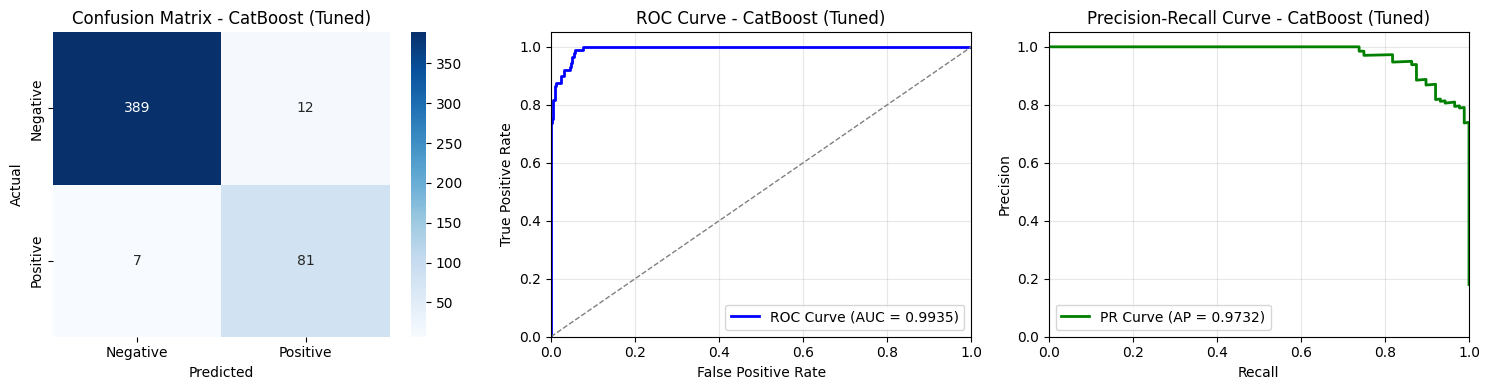

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
axes[0].set_title('Confusion Matrix - CatBoost (Tuned)')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
axes[1].plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
axes[1].plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve - CatBoost (Tuned)')
axes[1].legend(loc='lower right')
axes[1].grid(True, alpha=0.3)

precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
axes[2].plot(recall, precision, color='green', lw=2, label=f'PR Curve (AP = {avg_precision:.4f})')
axes[2].set_xlim([0.0, 1.0])
axes[2].set_ylim([0.0, 1.05])
axes[2].set_xlabel('Recall')
axes[2].set_ylabel('Precision')
axes[2].set_title('Precision-Recall Curve - CatBoost (Tuned)')
axes[2].legend(loc='lower left')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Simpan Model Terbaik

In [11]:
os.makedirs(model_path, exist_ok=True)

joblib.dump(final_model, f"{model_path}/catboost_pipeline.joblib")

fitted_preprocessor = final_model.named_steps['scaler']
joblib.dump(fitted_preprocessor, f"{model_path}/scaler.joblib")

cv_scores = cross_val_score(final_model, X_train, y_train, cv=cv, scoring='recall')

evaluation_results = {
    'best_params': best_params_clean,
    'cv_score': float(study.best_value),
    'test_metrics': {
        'accuracy': float(accuracy),
        'recall': float(recall_val),
        'f1_score': float(f1),
        'roc_auc': float(roc_auc),
        'average_precision': float(avg_precision)
    },
    'cv_scores_per_fold': [float(x) for x in cv_scores],
    'cv_mean': float(cv_scores.mean()),
    'cv_std': float(cv_scores.std()),
    'note': 'Pipeline-based CV (no data leakage)'
}

os.makedirs(f"{result_path}/CatBoost_Tuned", exist_ok=True)
with open(f"{result_path}/CatBoost_Tuned/CatBoost_tuned_evaluation.json", 'w') as f:
    json.dump(evaluation_results, f, indent=4)

print("=" * 60)
print("MODEL DAN HASIL BERHASIL DISIMPAN")
print("=" * 60)

MODEL DAN HASIL BERHASIL DISIMPAN
